In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
path = Path("UTKFace/UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
print(len(filenames))
print(filenames[:3])

23706
['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg']


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [4]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [5]:
image_path

['23_1_2_20170116173143018.jpg.chip.jpg',
 '27_0_3_20170104214210099.jpg.chip.jpg',
 '33_1_0_20170105003407044.jpg.chip.jpg',
 '49_0_3_20170119202423862.jpg.chip.jpg',
 '34_0_0_20170104170338177.jpg.chip.jpg',
 '24_0_2_20170116165518844.jpg.chip.jpg',
 '35_1_0_20170113001111066.jpg.chip.jpg',
 '25_1_0_20170117142815331.jpg.chip.jpg',
 '80_1_0_20170110141320400.jpg.chip.jpg',
 '26_1_0_20170116175417440.jpg.chip.jpg',
 '68_1_0_20170103183639034.jpg.chip.jpg',
 '26_0_1_20170116225054291.jpg.chip.jpg',
 '1_1_4_20161221201846817.jpg.chip.jpg',
 '80_0_0_20170117204632601.jpg.chip.jpg',
 '21_1_2_20170116175226250.jpg.chip.jpg',
 '14_0_3_20170104225721488.jpg.chip.jpg',
 '9_1_3_20161219225144784.jpg.chip.jpg',
 '85_1_0_20170110181049060.jpg.chip.jpg',
 '54_0_4_20170117204427774.jpg.chip.jpg',
 '56_0_0_20170105173129526.jpg.chip.jpg',
 '30_1_0_20170117181542323.jpg.chip.jpg',
 '51_0_0_20170109012545153.jpg.chip.jpg',
 '45_0_1_20170117194133909.jpg.chip.jpg',
 '43_1_3_20170109141039762.jpg.chip.

# From Unstructured data to Structured data

In [6]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [7]:
df.head()

,image,age,gender
0,23_1_2_20170116173143018.jpg.chip.jpg,23,1
1,27_0_3_20170104214210099.jpg.chip.jpg,27,0
2,33_1_0_20170105003407044.jpg.chip.jpg,33,1
3,49_0_3_20170119202423862.jpg.chip.jpg,49,0
4,34_0_0_20170104170338177.jpg.chip.jpg,34,0


In [8]:
gender_dict = {0:"Male",1:"Female"}

In [9]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [10]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


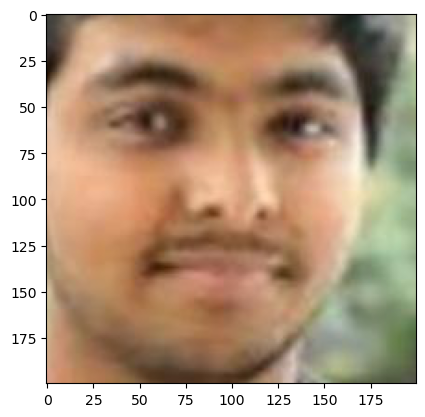

In [11]:
img = Image.open("UTKFace/UTKFace/"+df.image[1])
plt.imshow(img)

c:\Users\91626\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

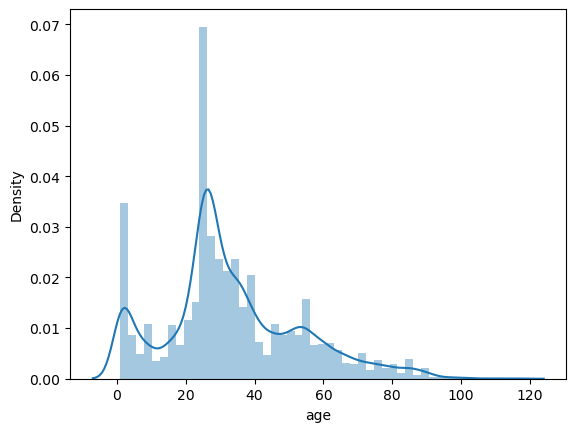

In [12]:
sns.distplot(df.age)

# Plotting Images

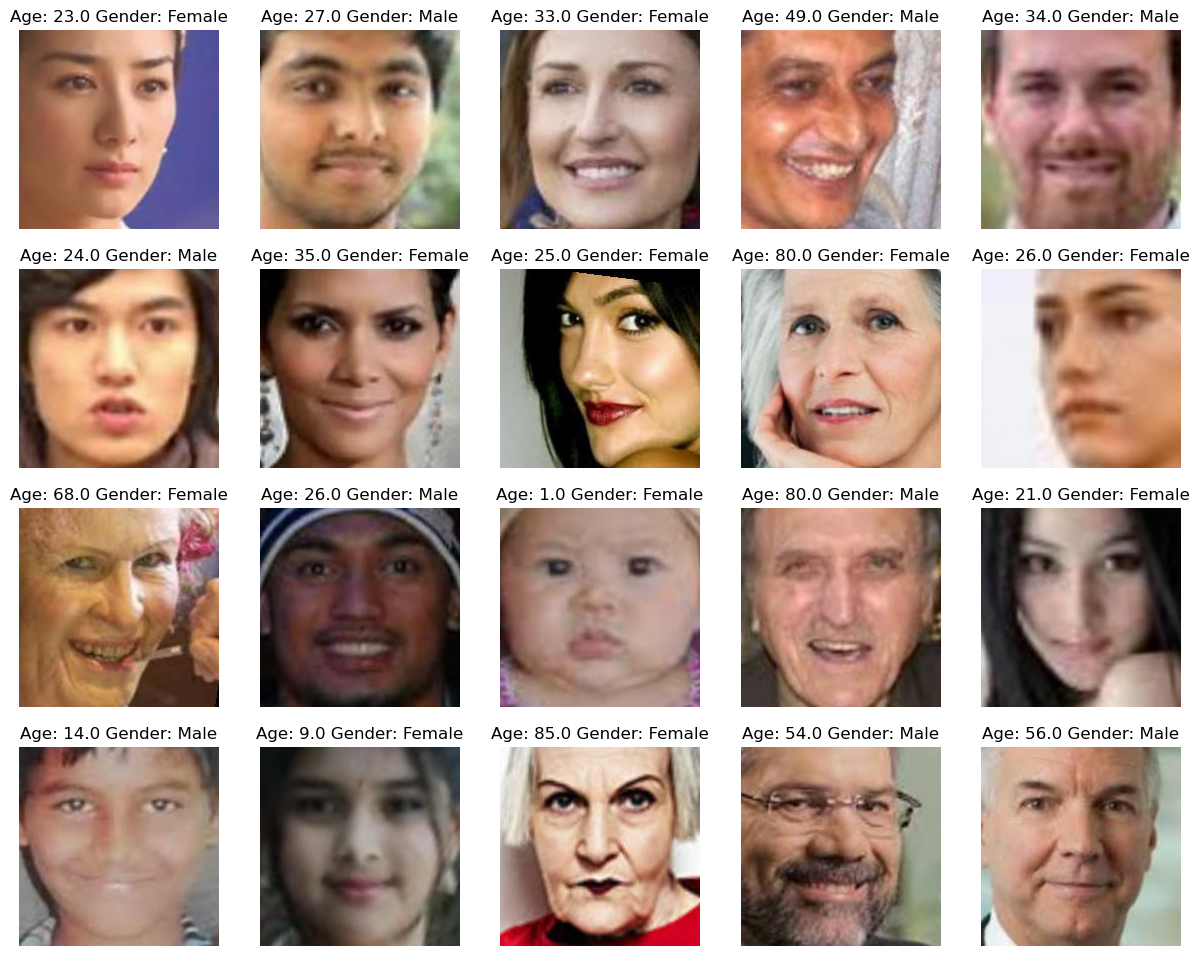

In [13]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset. 
I have already shuffled all the data to ensure no biasness in the dataset.

In [14]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [15]:
train.head()

,image,age,gender
18199,26_0_0_20170117172737876.jpg.chip.jpg,26.0,0
19557,31_1_0_20170117131145761.jpg.chip.jpg,31.0,1
20132,28_1_1_20170103182939570.jpg.chip.jpg,28.0,1
11849,37_0_3_20170117183448630.jpg.chip.jpg,37.0,0
2100,56_0_0_20170111203052213.jpg.chip.jpg,56.0,0


# Extracting Features

In [16]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

C:\Users\91626\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
C:\Users\91626\AppData\Local\Temp\ipykernel_15036\2903455783.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [17]:
x_train.shape

(3555, 128, 128, 1)

# Normalizing data

In [18]:
x_train = x_train/255

In [19]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [20]:
input_size = (128,128,1)

# Creating model

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D
from keras.optimizers import Adam

def inception_module(x, filters):
    branch1x1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)
    
    branch3x3 = Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    branch3x3 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(branch3x3)
    
    branch5x5 = Conv2D(filters=filters[3], kernel_size=1, activation='relu')(x)
    branch5x5 = Conv2D(filters=filters[4], kernel_size=5, padding='same', activation='relu')(branch5x5)
    
    branch_pool = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv2D(filters=filters[5], kernel_size=1, activation='relu')(branch_pool)
    
    output = Concatenate()([branch1x1, branch3x3, branch5x5, branch_pool])
    
    return output

input_shape = (128, 128, 1)
input_layer = Input(shape=input_shape)

# initial conv layer
x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# first inception module
x = inception_module(x, filters=[64, 96, 128, 16, 32, 32])

# second inception module
x = inception_module(x, filters=[128, 128, 192, 32, 96, 64])
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# third inception module
x = inception_module(x, filters=[192, 96, 208, 16, 48, 64])

# fourth inception module
x = inception_module(x, filters=[160, 112, 224, 24, 64, 64])
x = inception_module(x, filters=[128, 128, 256, 24, 64, 64])
x = inception_module(x, filters=[112, 144, 288, 32, 64, 64])

# fifth inception module
x = inception_module(x, filters=[256, 160, 320, 32, 128, 128])
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# global average pooling
x = AveragePooling2D(pool_size=7, strides=7, padding='same')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

# final output layer for binary classification
output_1 = Dense(units=1, activation='sigmoid', name='gender_output')(x)
output_2 = Dense(units=1, activation='relu', name='age_output')(x)

model = Model(inputs=input_layer, outputs=[output_1, output_2])
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 96)   6240        ['max_pooling2d[0][0]']      

C:\Users\91626\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 dropout (Dropout)              (None, 2, 2, 832)    0           ['average_pooling2d[0][0]']      
                                                                                                  
 flatten (Flatten)              (None, 3328)         0           ['dropout[0][0]']                
                                                                                                  
 gender_output (Dense)          (None, 1)            3329        ['flatten[0][0]']                
                                                                                                  
 age_output (Dense)             (None, 1)            3329        ['flatten[0][0]']                
                                                                                                  
Total params: 3,344,834
Trainable params: 3,344,834
Non-trainable params: 0
_________________________________

# Training the model

In [22]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
320/320 [==============================] - 492s 2s/step - loss: 23.5537 - gender_output_loss: 0.7582 - age_output_loss: 22.7956 - gender_output_accuracy: 0.5086 - age_output_accuracy: 0.0347 - val_loss: 14.7170 - val_gender_output_loss: 0.6904 - val_age_output_loss: 14.0265 - val_gender_output_accuracy: 0.5309 - val_age_output_accuracy: 0.0337
Epoch 2/20
320/320 [==============================] - 501s 2s/step - loss: 16.5724 - gender_output_loss: 0.7545 - age_output_loss: 15.8179 - gender_output_accuracy: 0.4970 - age_output_accuracy: 0.0469 - val_loss: 14.9832 - val_gender_output_loss: 0.6953 - val_age_output_loss: 14.2879 - val_gender_output_accuracy: 0.4663 - val_age_output_accuracy: 0.0337
Epoch 3/20
320/320 [==============================] - 477s 1s/step - loss: 16.1565 - gender_output_loss: 0.7305 - age_output_loss: 15.4261 - gender_output_accuracy: 0.5123 - age_output_accuracy: 0.0469 - val_loss: 14.1019 - val_gender_output_loss: 0.6955 - val_age_output_loss: 13.4064 

# Visualizing loss

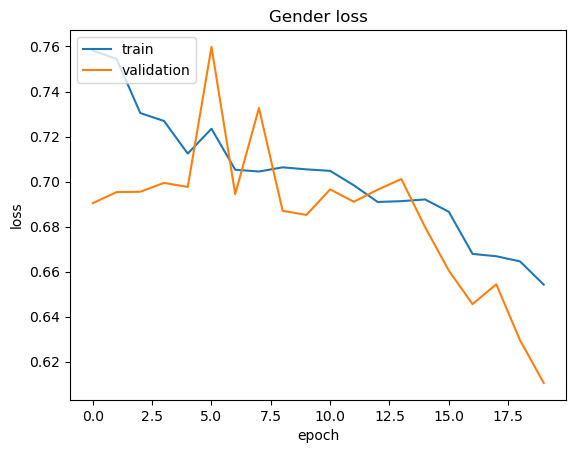

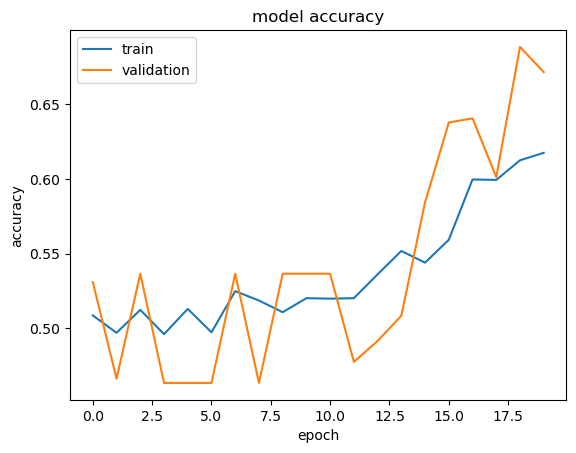

In [27]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

hist=model_history

plt.plot(hist.history['gender_output_accuracy'])
plt.plot(hist.history['val_gender_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

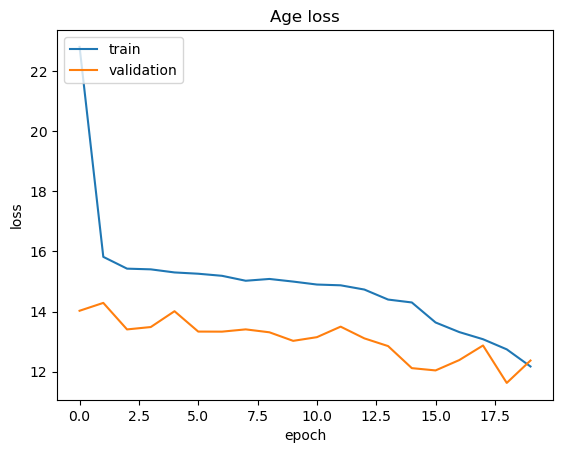

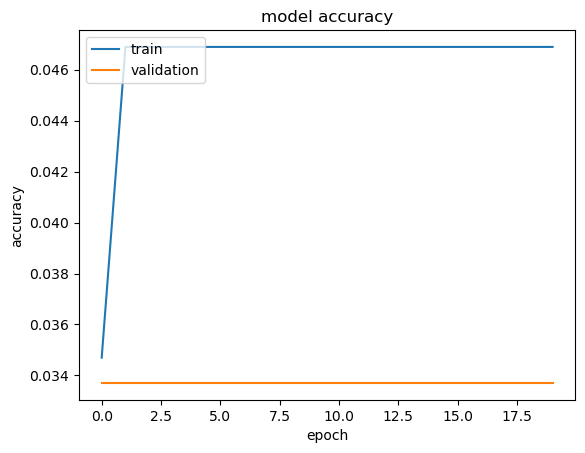

In [28]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['age_output_accuracy'])
plt.plot(hist.history['val_age_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test image

Original: Gender =  Male  Age =  42.0
1/1 [==============================] - 0s 133ms/step
Prediction: Gender =  Male  Age =  39


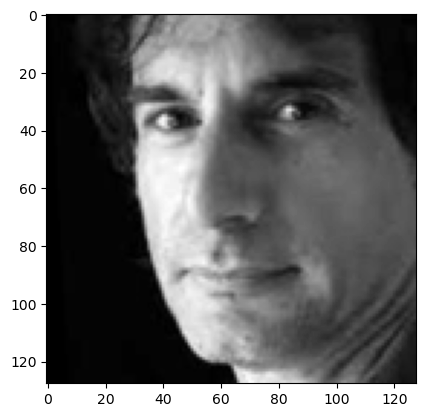

In [34]:
index=175
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

Original: Gender =  Female  Age =  29.0
1/1 [==============================] - 0s 106ms/step
Prediction: Gender =  Female  Age =  33


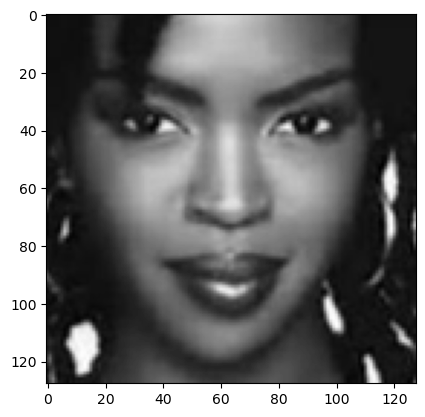

In [31]:
index=890
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')